### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import os
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.models import load_model

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


#### Tracking the state-action pairs for checking convergence


In [4]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

In [5]:
#This function will initialise the 7 Q-values which need to be tracked for checking convergence

#iters = []                            #the x-axis of convergence graphs

def initialise_tracking_states():
    sample_q_values = [((1,9,1),(1,2)),((1,11,3),(1,3)),((1,20,5),(2,4)),((4,10,5),(3,1)),((3,13,0),(3,1)),((0,9,6),(1,3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [6]:
#This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states(actions_list, qvalues, state):
    if state in States_track.keys():
        action = list(States_track[state].keys())
        ind = actions_list.index(action[0])
        qv = qvalues[0][ind]
        States_track[state][action[0]].append(qv)

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_pickle(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.input_size = state_size   # input for NN which is size of state + size of action
        self.output_size = action_size # output of NN which is 

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01     
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.batch_size = 32 
        self.epsilon_decay = -0.0005
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        self.special_states_tracked = []
        
         # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets     
        
        # hidden layers
        model.add(Dense(32, input_dim=self.input_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.output_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment 
        action_index, all_actions = env.requests(state)
#          print(all_actions)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return random.choice(action_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            action_dict = {}
            input_nn = env.state_encod_arch1(state)
            input_nn = input_nn.reshape(1, self.input_size)
            q_value = self.model.predict(input_nn)
            save_tracking_states(env.action_space, q_value, state)
            for ind in action_index:
                action_dict[ind] = q_value[0][ind]
            max_qvalue_action = max(action_dict, key=action_dict.get)
            return max_qvalue_action
        

    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
     self.memory.append((state, action, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.input_size))
            update_input =np.zeros((self.batch_size, self.input_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                state_input_nn = env.state_encod_arch1(state)
                state_input_nn = state_input_nn.reshape(1, self.input_size)
                update_input[i] = state_input_nn
                actions.append(action)
                rewards.append(reward)
                next_state_input_nn = env.state_encod_arch1(state)
                next_state_input_nn = next_state_input_nn.reshape(1, self.input_size)
                update_output[i] = next_state_input_nn
                done.append(done_boolean)
                
                # Write your code from here
                # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    #print("thu")
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.special_states_tracked.append(q_value[0][2])
            

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
    

In [9]:
# Invoke Env class
env = CabDriver()
Episodes = 12000
Save_Rewards_After_Ep = 50
Save_Weights_After_Ep = 50
rewards_per_episode, episodes = [], []
agent = DQNAgent(36,21)
initialise_tracking_states()

In [11]:
# Episodes = 5
# agent = DQNAgent(36,21)

In [12]:
# agent.model.load_weights("model_weights")

### DQN block

In [13]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver()
    all_actions, all_state, curr_state = env.reset()
    terminal_state = False
    revenue = 0
    #Call the DQN agent
    ep_start_hour = curr_state[1]
    ep_end_hour = curr_state[1] + 24 * 30
    #print("ep {0}".format(episode))
    
    while terminal_state == False:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        fin_action_index = agent.get_action(curr_state, env)
        
                
            
        next_state, reward, total_hours_lapsed = env.step(curr_state, fin_action_index, Time_matrix)
        ep_start_hour += total_hours_lapsed
            
        if ep_start_hour >= ep_end_hour:
            terminal_state = True
            
        agent.append_sample(curr_state, fin_action_index, reward, next_state, terminal_state)
        
        agent.train_model()
        revenue += reward
        #print("reward = {0}".format(reward)) 
        curr_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(revenue)
    episodes.append(episode) 
    
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # save rewards_per_episode
    if episode % Save_Rewards_After_Ep == 0: 
        save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")
    
    if episode % Save_Rewards_After_Ep == 0:     
        save_pickle(States_track,'saved_pickle_files/States_tracked') 
        
    if ((episode + 1) % 5 == 0):
        print("reward after ep {0} = {1}".format(episode, revenue))
        agent.save_tracking_states()
        
        
    if(episode % Save_Weights_After_Ep == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
            
        

Saving Model 0
reward after ep 4 = -68.0
reward after ep 9 = -244.0
reward after ep 14 = -222.0
reward after ep 19 = -241.0
reward after ep 24 = -248.0
reward after ep 29 = -298.0
reward after ep 34 = 52.0
reward after ep 39 = 9.0
reward after ep 44 = -344.0
reward after ep 49 = -105.0
Saving Model 50
reward after ep 54 = -335.0
reward after ep 59 = -117.0
reward after ep 64 = 111.0
reward after ep 69 = -297.0
reward after ep 74 = 88.0
reward after ep 79 = -61.0
reward after ep 84 = 36.0
reward after ep 89 = 130.0
reward after ep 94 = -312.0
reward after ep 99 = -181.0
Saving Model 100
reward after ep 104 = -167.0
reward after ep 109 = -498.0
reward after ep 114 = 228.0
reward after ep 119 = -194.0
reward after ep 124 = 108.0
reward after ep 129 = -400.0
reward after ep 134 = -216.0
reward after ep 139 = -172.0
reward after ep 144 = -90.0
reward after ep 149 = 36.0
Saving Model 150
reward after ep 154 = 73.0
reward after ep 159 = 117.0
reward after ep 164 = -279.0
reward after ep 169 =

reward after ep 1374 = 517.0
reward after ep 1379 = 199.0
reward after ep 1384 = 228.0
reward after ep 1389 = 674.0
reward after ep 1394 = 562.0
reward after ep 1399 = 558.0
Saving Model 1400
reward after ep 1404 = 631.0
reward after ep 1409 = 499.0
reward after ep 1414 = 460.0
reward after ep 1419 = 581.0
reward after ep 1424 = 654.0
reward after ep 1429 = 519.0
reward after ep 1434 = 637.0
reward after ep 1439 = 213.0
reward after ep 1444 = 639.0
reward after ep 1449 = 493.0
Saving Model 1450
reward after ep 1454 = 732.0
reward after ep 1459 = 175.0
reward after ep 1464 = 854.0
reward after ep 1469 = 760.0
reward after ep 1474 = 386.0
reward after ep 1479 = 683.0
reward after ep 1484 = 482.0
reward after ep 1489 = 475.0
reward after ep 1494 = 911.0
reward after ep 1499 = 650.0
Saving Model 1500
reward after ep 1504 = 683.0
reward after ep 1509 = 566.0
reward after ep 1514 = 352.0
reward after ep 1519 = 378.0
reward after ep 1524 = 918.0
reward after ep 1529 = 876.0
reward after ep 15

Saving Model 2700
reward after ep 2704 = 864.0
reward after ep 2709 = 782.0
reward after ep 2714 = 1060.0
reward after ep 2719 = 1003.0
reward after ep 2724 = 438.0
reward after ep 2729 = 523.0
reward after ep 2734 = 1065.0
reward after ep 2739 = 757.0
reward after ep 2744 = 692.0
reward after ep 2749 = 1066.0
Saving Model 2750
reward after ep 2754 = 844.0
reward after ep 2759 = 894.0
reward after ep 2764 = 785.0
reward after ep 2769 = 625.0
reward after ep 2774 = 885.0
reward after ep 2779 = 949.0
reward after ep 2784 = 494.0
reward after ep 2789 = 473.0
reward after ep 2794 = 560.0
reward after ep 2799 = 1058.0
Saving Model 2800
reward after ep 2804 = 787.0
reward after ep 2809 = 1066.0
reward after ep 2814 = 1368.0
reward after ep 2819 = 1215.0
reward after ep 2824 = 758.0
reward after ep 2829 = 727.0
reward after ep 2834 = 749.0
reward after ep 2839 = 823.0
reward after ep 2844 = 1125.0
reward after ep 2849 = 886.0
Saving Model 2850
reward after ep 2854 = 640.0
reward after ep 2859

reward after ep 4024 = 931.0
reward after ep 4029 = 855.0
reward after ep 4034 = 976.0
reward after ep 4039 = 760.0
reward after ep 4044 = 1162.0
reward after ep 4049 = 951.0
Saving Model 4050
reward after ep 4054 = 1162.0
reward after ep 4059 = 957.0
reward after ep 4064 = 698.0
reward after ep 4069 = 1044.0
reward after ep 4074 = 875.0
reward after ep 4079 = 1044.0
reward after ep 4084 = 858.0
reward after ep 4089 = 949.0
reward after ep 4094 = 1044.0
reward after ep 4099 = 1011.0
Saving Model 4100
reward after ep 4104 = 890.0
reward after ep 4109 = 1001.0
reward after ep 4114 = 944.0
reward after ep 4119 = 875.0
reward after ep 4124 = 958.0
reward after ep 4129 = 992.0
reward after ep 4134 = 629.0
reward after ep 4139 = 1283.0
reward after ep 4144 = 986.0
reward after ep 4149 = 691.0
Saving Model 4150
reward after ep 4154 = 1048.0
reward after ep 4159 = 519.0
reward after ep 4164 = 771.0
reward after ep 4169 = 929.0
reward after ep 4174 = 1178.0
reward after ep 4179 = 949.0
reward a

reward after ep 5339 = 876.0
reward after ep 5344 = 864.0
reward after ep 5349 = 1188.0
Saving Model 5350
reward after ep 5354 = 721.0
reward after ep 5359 = 1178.0
reward after ep 5364 = 1085.0
reward after ep 5369 = 683.0
reward after ep 5374 = 1106.0
reward after ep 5379 = 508.0
reward after ep 5384 = 1088.0
reward after ep 5389 = 918.0
reward after ep 5394 = 762.0
reward after ep 5399 = 1065.0
Saving Model 5400
reward after ep 5404 = 1032.0
reward after ep 5409 = 992.0
reward after ep 5414 = 993.0
reward after ep 5419 = 1026.0
reward after ep 5424 = 817.0
reward after ep 5429 = 1128.0
reward after ep 5434 = 1061.0
reward after ep 5439 = 589.0
reward after ep 5444 = 798.0
reward after ep 5449 = 1064.0
Saving Model 5450
reward after ep 5454 = 809.0
reward after ep 5459 = 981.0
reward after ep 5464 = 520.0
reward after ep 5469 = 1030.0
reward after ep 5474 = 1027.0
reward after ep 5479 = 729.0
reward after ep 5484 = 693.0
reward after ep 5489 = 814.0
reward after ep 5494 = 931.0
rewar

reward after ep 6659 = 828.0
reward after ep 6664 = 1036.0
reward after ep 6669 = 808.0
reward after ep 6674 = 885.0
reward after ep 6679 = 782.0
reward after ep 6684 = 1026.0
reward after ep 6689 = 686.0
reward after ep 6694 = 810.0
reward after ep 6699 = 1172.0
Saving Model 6700
reward after ep 6704 = 948.0
reward after ep 6709 = 691.0
reward after ep 6714 = 1147.0
reward after ep 6719 = 723.0
reward after ep 6724 = 787.0
reward after ep 6729 = 753.0
reward after ep 6734 = 707.0
reward after ep 6739 = 966.0
reward after ep 6744 = 840.0
reward after ep 6749 = 764.0
Saving Model 6750
reward after ep 6754 = 792.0
reward after ep 6759 = 648.0
reward after ep 6764 = 816.0
reward after ep 6769 = 801.0
reward after ep 6774 = 702.0
reward after ep 6779 = 673.0
reward after ep 6784 = 1098.0
reward after ep 6789 = 740.0
reward after ep 6794 = 822.0
reward after ep 6799 = 906.0
Saving Model 6800
reward after ep 6804 = 791.0
reward after ep 6809 = 666.0
reward after ep 6814 = 1057.0
reward after

reward after ep 7989 = 443.0
reward after ep 7994 = 876.0
reward after ep 7999 = 1086.0
Saving Model 8000
reward after ep 8004 = 648.0
reward after ep 8009 = 609.0
reward after ep 8014 = 694.0
reward after ep 8019 = 7.0
reward after ep 8024 = 524.0
reward after ep 8029 = 570.0
reward after ep 8034 = 968.0
reward after ep 8039 = 1097.0
reward after ep 8044 = 598.0
reward after ep 8049 = 892.0
Saving Model 8050
reward after ep 8054 = 565.0
reward after ep 8059 = 848.0
reward after ep 8064 = 594.0
reward after ep 8069 = 785.0
reward after ep 8074 = 705.0
reward after ep 8079 = 767.0
reward after ep 8084 = 832.0
reward after ep 8089 = 746.0
reward after ep 8094 = 950.0
reward after ep 8099 = -55.0
Saving Model 8100
reward after ep 8104 = 1042.0
reward after ep 8109 = 822.0
reward after ep 8114 = 1081.0
reward after ep 8119 = 912.0
reward after ep 8124 = 525.0
reward after ep 8129 = 939.0
reward after ep 8134 = 519.0
reward after ep 8139 = 1012.0
reward after ep 8144 = 246.0
reward after ep

reward after ep 9319 = 937.0
reward after ep 9324 = 1026.0
reward after ep 9329 = 558.0
reward after ep 9334 = 747.0
reward after ep 9339 = 839.0
reward after ep 9344 = 823.0
reward after ep 9349 = 654.0
Saving Model 9350
reward after ep 9354 = 852.0
reward after ep 9359 = 404.0
reward after ep 9364 = 1007.0
reward after ep 9369 = 575.0
reward after ep 9374 = 867.0
reward after ep 9379 = 765.0
reward after ep 9384 = 810.0
reward after ep 9389 = 364.0
reward after ep 9394 = 539.0
reward after ep 9399 = 644.0
Saving Model 9400
reward after ep 9404 = 565.0
reward after ep 9409 = 714.0
reward after ep 9414 = 854.0
reward after ep 9419 = 852.0
reward after ep 9424 = 801.0
reward after ep 9429 = 517.0
reward after ep 9434 = 551.0
reward after ep 9439 = 773.0
reward after ep 9444 = 290.0
reward after ep 9449 = 778.0
Saving Model 9450
reward after ep 9454 = 747.0
reward after ep 9459 = 576.0
reward after ep 9464 = 852.0
reward after ep 9469 = 656.0
reward after ep 9474 = 768.0
reward after ep 

reward after ep 10629 = 588.0
reward after ep 10634 = 489.0
reward after ep 10639 = 533.0
reward after ep 10644 = 606.0
reward after ep 10649 = 459.0
Saving Model 10650
reward after ep 10654 = 454.0
reward after ep 10659 = 528.0
reward after ep 10664 = 382.0
reward after ep 10669 = 538.0
reward after ep 10674 = 431.0
reward after ep 10679 = 565.0
reward after ep 10684 = 917.0
reward after ep 10689 = 542.0
reward after ep 10694 = 636.0
reward after ep 10699 = 422.0
Saving Model 10700
reward after ep 10704 = 580.0
reward after ep 10709 = 515.0
reward after ep 10714 = 607.0
reward after ep 10719 = 621.0
reward after ep 10724 = 534.0
reward after ep 10729 = 791.0
reward after ep 10734 = 728.0
reward after ep 10739 = 535.0
reward after ep 10744 = 660.0
reward after ep 10749 = 571.0
Saving Model 10750
reward after ep 10754 = 546.0
reward after ep 10759 = 326.0
reward after ep 10764 = 492.0
reward after ep 10769 = 465.0
reward after ep 10774 = 600.0
reward after ep 10779 = 585.0
reward after 

reward after ep 11914 = 496.0
reward after ep 11919 = 773.0
reward after ep 11924 = 690.0
reward after ep 11929 = 766.0
reward after ep 11934 = 493.0
reward after ep 11939 = 480.0
reward after ep 11944 = 1002.0
reward after ep 11949 = 595.0
Saving Model 11950
reward after ep 11954 = 742.0
reward after ep 11959 = 270.0
reward after ep 11964 = 685.0
reward after ep 11969 = 632.0
reward after ep 11974 = 494.0
reward after ep 11979 = 576.0
reward after ep 11984 = 756.0
reward after ep 11989 = 566.0
reward after ep 11994 = 517.0
reward after ep 11999 = 702.0


### Tracking Convergence

In [2]:
print("Average reward of last 8000 episodes is {0}".format(np.max(rewards_per_episode[-8000:])))

NameError: name 'np' is not defined

In [1]:
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
print(len(rewards_per_episode))

# save plots in saved_plots/ directory
plt.savefig('rewards.png')

print("Average reward of last 8000 episodes is {0}".format(np.mean(rewards_per_episode[-8000:])))

NameError: name 'pickle' is not defined

In [24]:
state_tracked_sample = [agent.special_states_tracked[i] for i in range(len(agent.special_states_tracked)) if agent.special_states_tracked[i] < 1000]

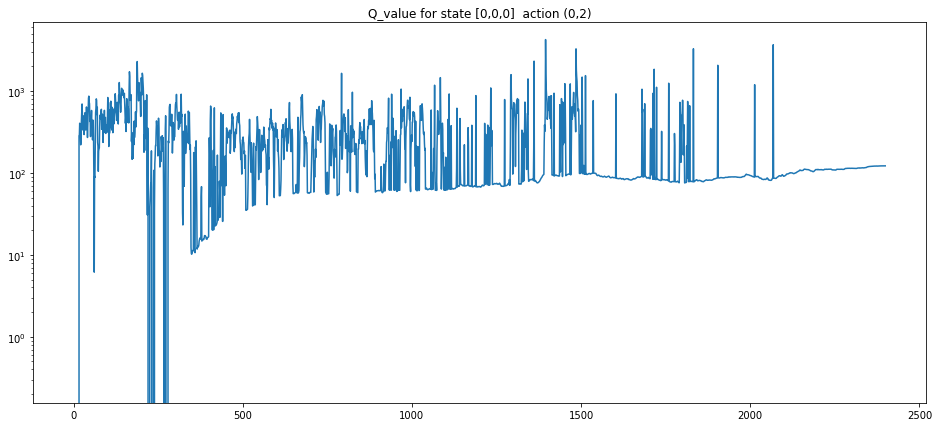

In [25]:
# Tracked a special state
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.special_states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.special_states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,100)
epsilon = []
for i in range(0,3000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))
   # epsilon.append(np.random.rand())
print(epsilon)

In [ ]:
plt.plot(time, epsilon)
plt.show()